In [1]:
import os
import pickle
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor  # pip install xgboost
from xgbexcel import XGBtoExcel
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
!pip install xgbexcel


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


# Считывание данных

In [3]:
convert = lambda x: x if 0 < x > 150 else 0
convert = np.vectorize(convert)

Функция для нормализации предсказаний

Предсказаний меньше нуля никак не может быть, так что мы можем ограничить все предсказания

In [4]:
warnings.filterwarnings("ignore")

Отключение предупреждений от моделей

In [5]:
if not os.path.isdir("raw_data"):
    os.chdir("../")

Установка рабочей директории (тк данные располагаются на папку выше)

In [6]:
data = pd.read_excel("raw_data/Статистика_для_графиков_3_д_ТЭЦ2_УРУТ_130.xlsx")

In [7]:
data.columns

Index([                                                  'Дата',
                           'Выработка электроэнергии ТА гр.130',
                                 'Отпуск тепла из ТО ТА гр.130',
       'Удельный расход условного топлива на отпуск э/э гр.130',
                                                   'Unnamed: 4',
                                       'Предсказание полином 2',
                                           0.033374592702317095],
      dtype='object')

Считывание данных

# Предобработка данных

In [8]:
target = "Удельный расход условного топлива на отпуск э/э гр.130"

In [9]:
columns_for_predictions = [
    column
    for column in data.columns[:-1]
    if "130" in column and column != "Удельный расход тепла на выработку э/э ТА гр.130"
]

Получаем все колонки, связанные с "Удельный расход условного топлива на отпуск э/э гр.130"

In [10]:
columns_for_predictions

['Выработка электроэнергии ТА гр.130',
 'Отпуск тепла из ТО ТА гр.130',
 'Удельный расход условного топлива на отпуск э/э гр.130']

In [11]:
data.isna().sum()

Дата                                                         0
Выработка электроэнергии ТА гр.130                           0
Отпуск тепла из ТО ТА гр.130                                 0
Удельный расход условного топлива на отпуск э/э гр.130       0
Unnamed: 4                                                1090
Предсказание полином 2                                       0
0.033374592702317095                                         0
dtype: int64

In [12]:
date = np.array([[0, 0, 0]], dtype=int)
for i in data["Дата"]:
    date = np.vstack([date, str(i.date()).split("-")])

In [13]:
date = date[1:]

In [14]:
data["year"] = date[:, 0]
data.year = data.year.apply(int)

In [15]:
data["month"] = date[:, 1]
data.month = data.month.apply(int)

In [16]:
data["day"] = date[:, 2]
data.day = data.day.apply(int)

In [17]:
data = data.drop(["Дата"], axis=1)

In [18]:
data = data[columns_for_predictions + ["day", "month", "year"]]

# Обработка выбросов

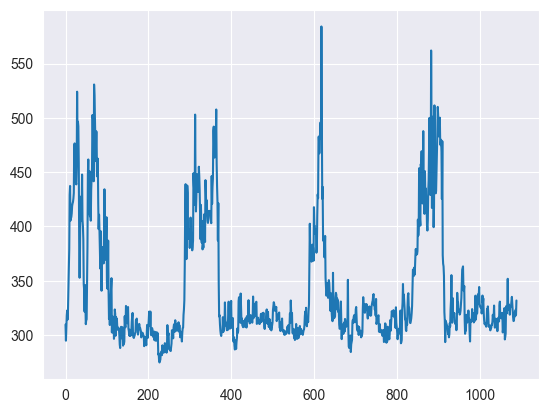

In [19]:
plt.plot(data[target]);

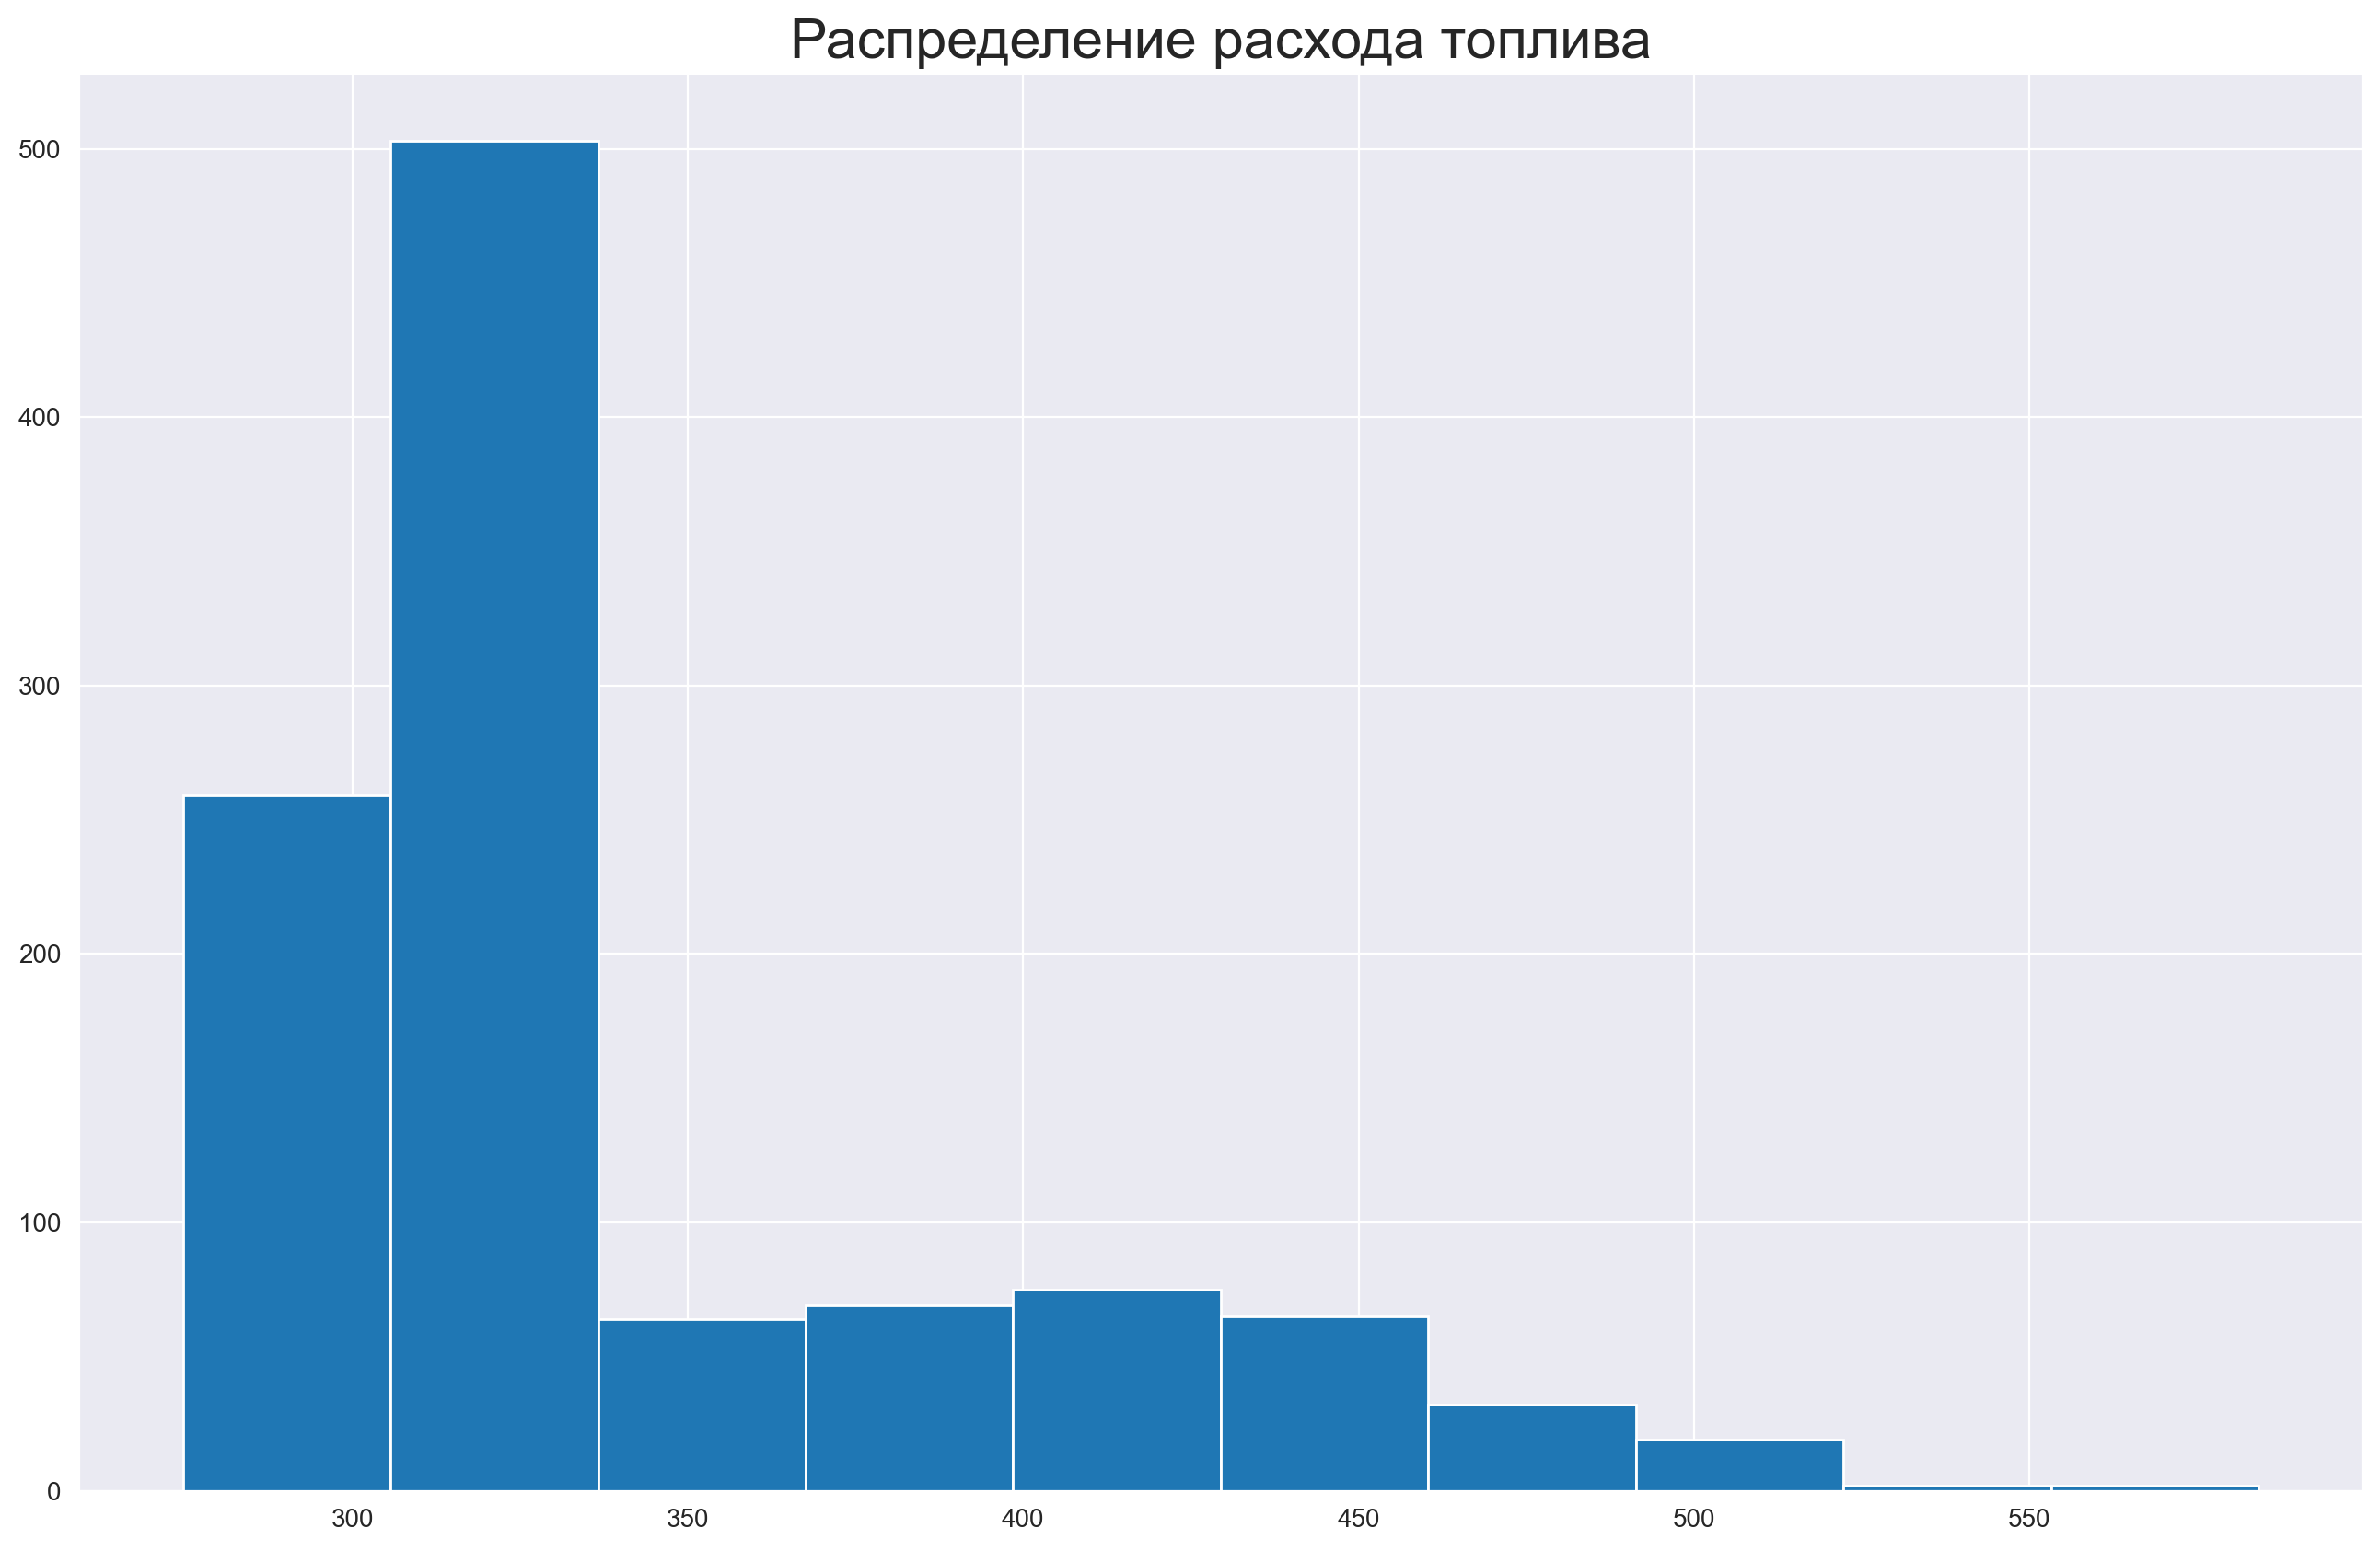

In [20]:
plt.figure(figsize=(16, 10), dpi=200)
plt.title('Распределение расхода топлива', fontsize=22)
# plt.legend()
plt.hist(data[target]);

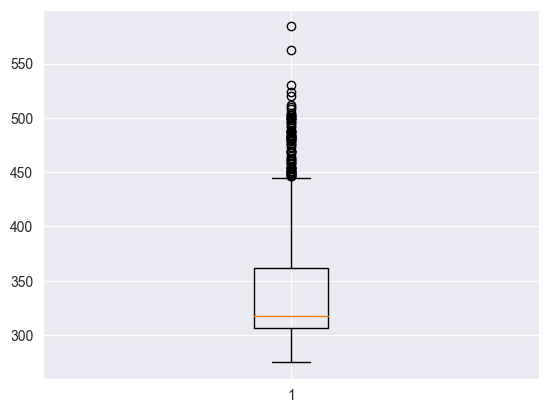

In [21]:
plt.boxplot(data[target]);

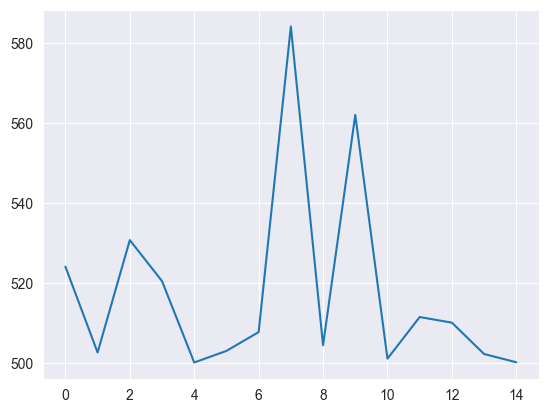

In [22]:
plt.plot(np.array(data.loc[data[target] > 500][target]));

In [23]:
data = data.loc[data[target] < 507]
data = data.loc[data[target] > 100]

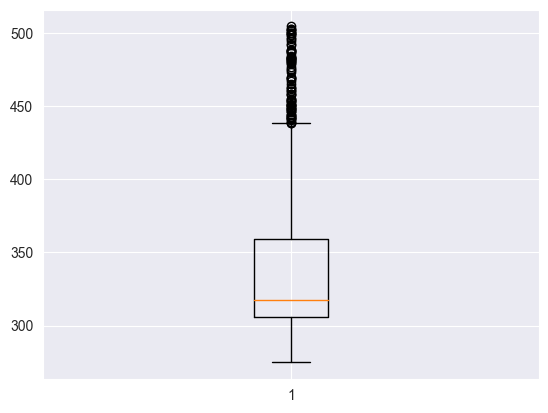

In [24]:
plt.boxplot(data[target]);

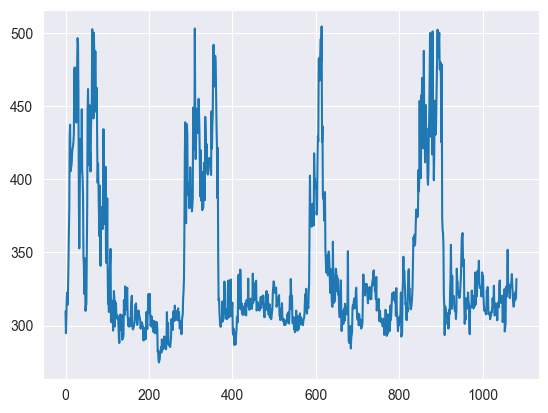

In [25]:
plt.plot(np.array(data[target]));

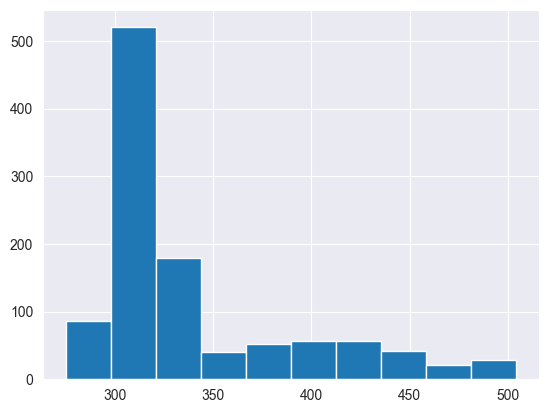

In [26]:
plt.hist(data[target]);

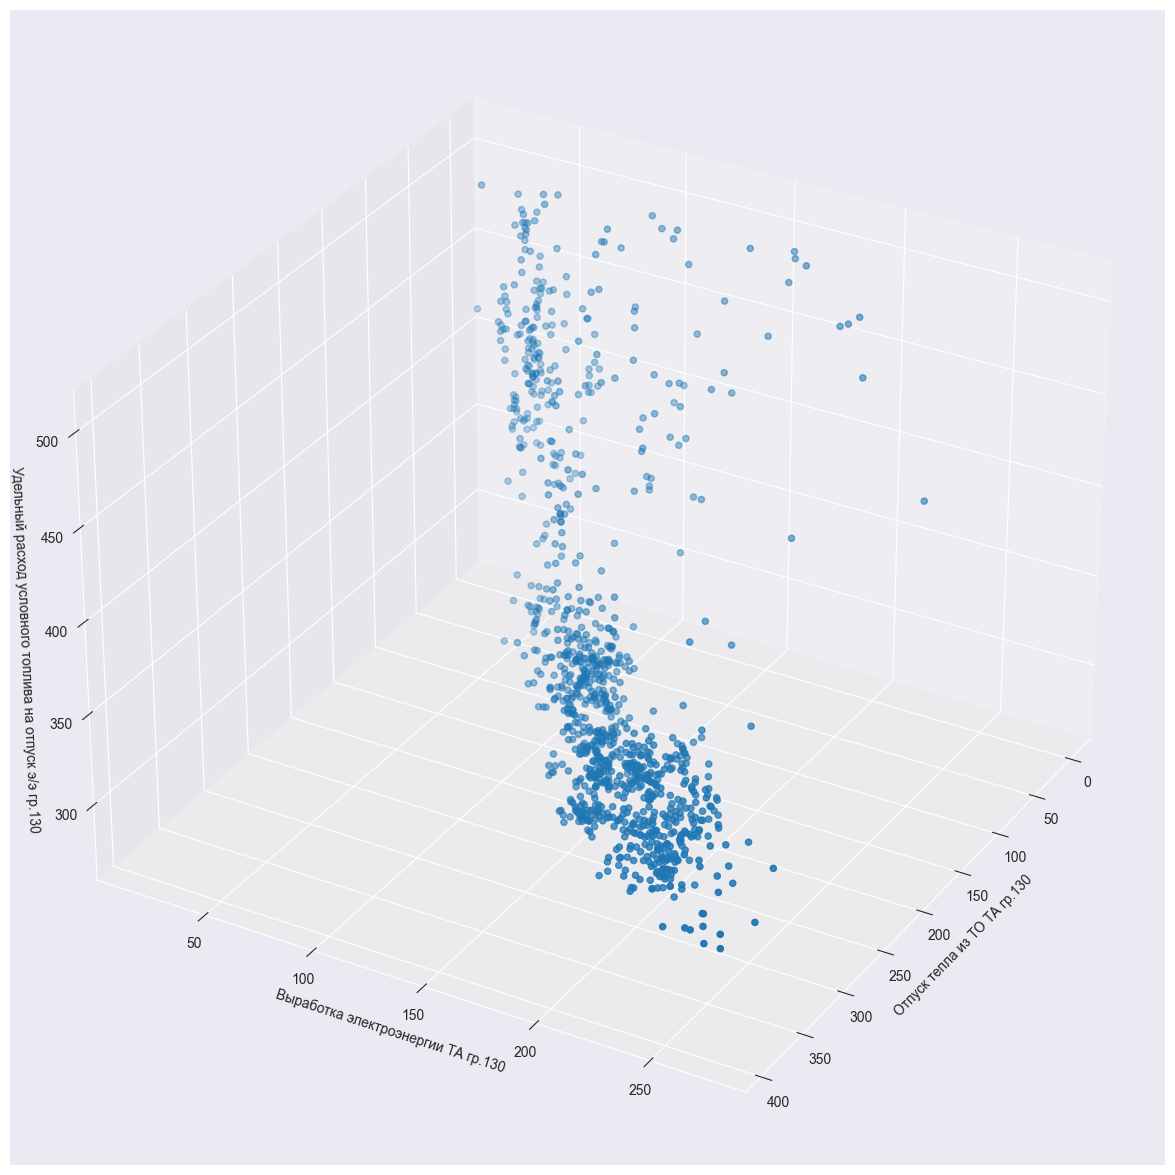

In [27]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
fig.set_figheight(15)
fig.set_figwidth(15)
ax.scatter(
    data[columns_for_predictions[1]],
    data[columns_for_predictions[0]],
    data[columns_for_predictions[2]]
)

ax.view_init(30, 30)
ax.set_xlabel(columns_for_predictions[1])
ax.set_ylabel(columns_for_predictions[0])
ax.set_zlabel(columns_for_predictions[2]);

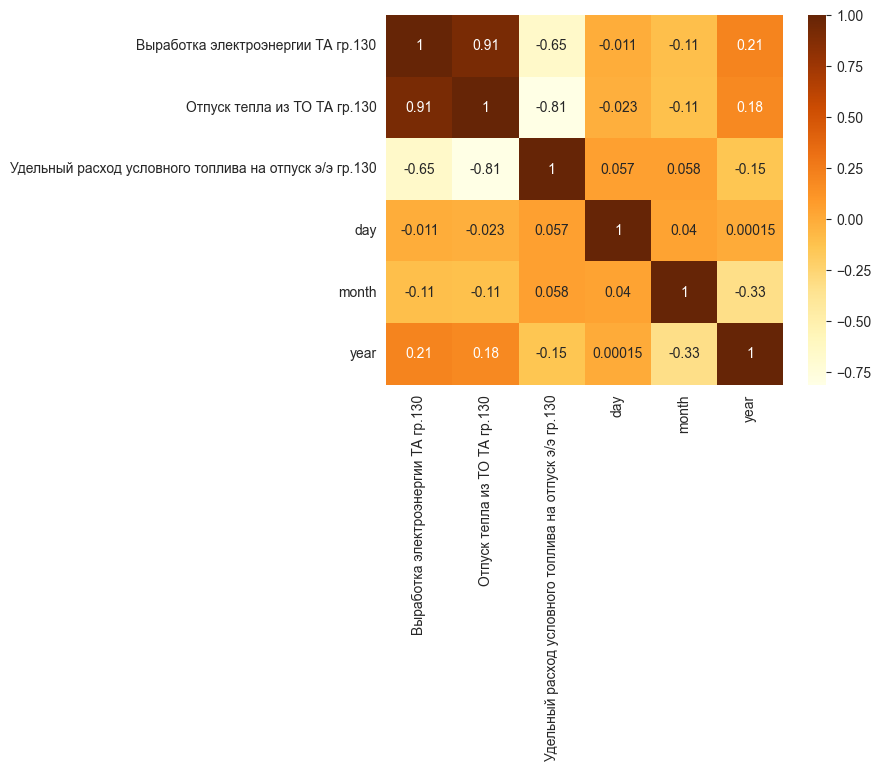

In [28]:
sns.heatmap(
    data.corr(), annot=True,
    cmap=sns.color_palette("YlOrBr", as_cmap=True)
);

# Создание датасета для обучения
## Разделение данных

In [29]:
X = data.drop(target, axis=1)

In [30]:
y = data[target]

In [31]:
out_shape = 1

# Разделение на тренировочную и тестовую выборки

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=30)

# XGB

In [33]:
model = XGBRegressor()

In [34]:
X = np.array(X)
y = np.array(y)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [35]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

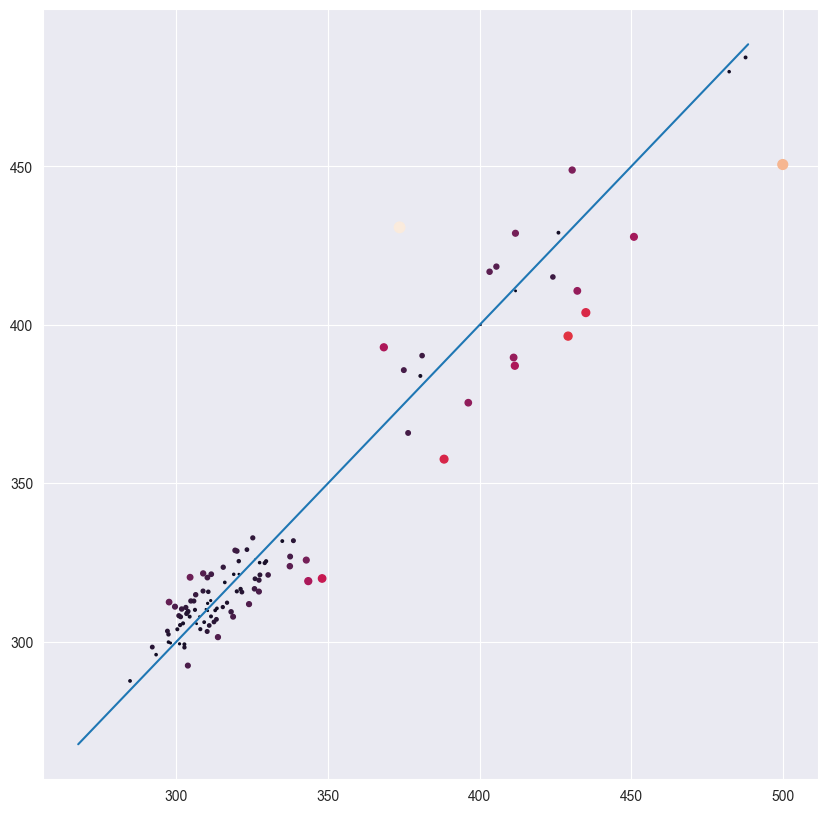

In [36]:
test_predictions = np.array(model.predict(X_test))
area = abs(y_test - test_predictions)
plt.figure(figsize=(10, 10))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(y_test, test_predictions, marker='o', s=area, c=area);

In [37]:
predictions = np.array(model.predict(X_test))

In [38]:
# data["predictions"] = predictions
# data.to_excel("Статистика для графиков 3 д ТЭЦ2 (УРУТ-130).xlsx")

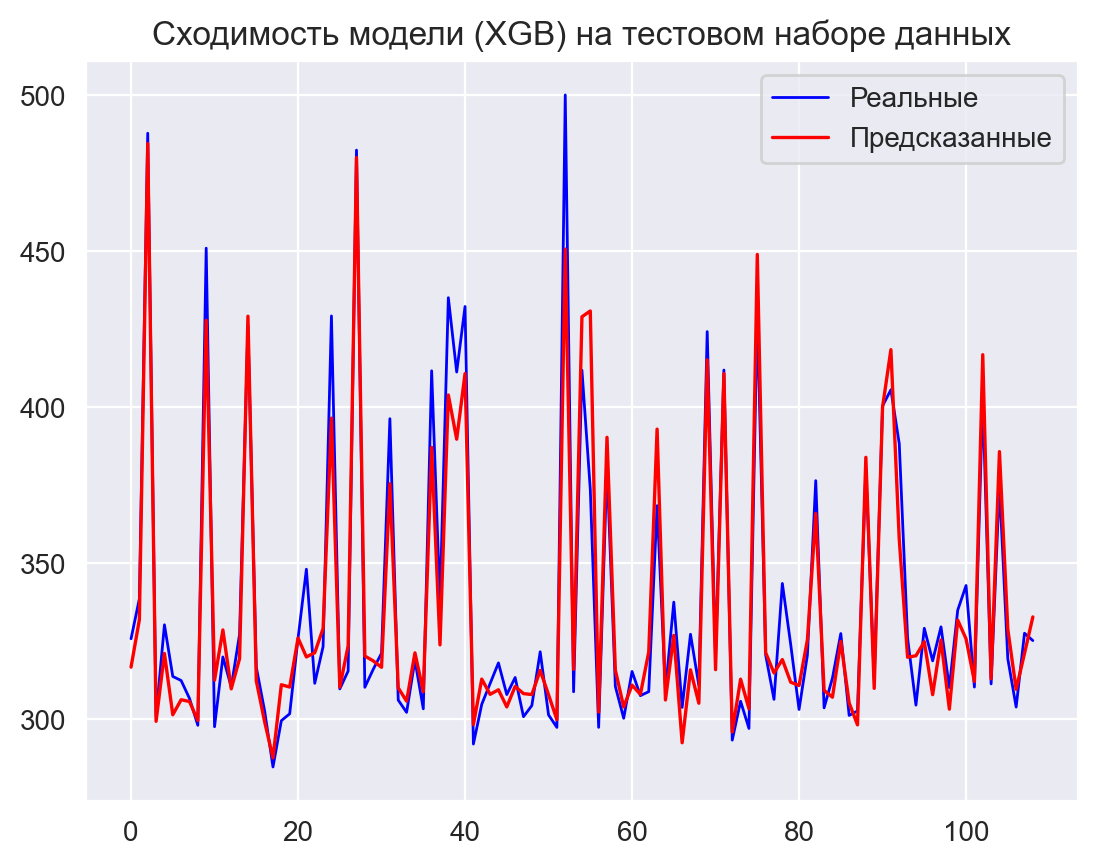

In [39]:
plt.figure(dpi=200)
plt.title("Сходимость модели (XGB) на тестовом наборе данных")
plt.plot(y_test, color="blue", label="Реальные", linewidth=1)
plt.plot(predictions, "r", label="Предсказанные", linewidth=1.2)
plt.legend()
plt.savefig("predictions/graphs/xgb_test_plot.png")
plt.savefig("predictions/graphs/xgb_test_plot.svg")
plt.show()

In [40]:
r2_score(y_test, predictions)

0.9234651571100364

In [41]:
for real, pred in zip(y_test, predictions):
    if abs(real - pred) > 20:
        print(
            "real: {0}, pred: {1}, diff: {2}".format(
                real, pred, abs(real - pred)
            )
        )

real: 450.898516, pred: 427.7822265625, diff: 23.116289437499972
real: 348.03684, pred: 319.92706298828125, diff: 28.109777011718734
real: 429.177924, pred: 396.4405822753906, diff: 32.737341724609394
real: 396.255965, pred: 375.41571044921875, diff: 20.840254550781253
real: 411.607633, pred: 387.0857849121094, diff: 24.521848087890646
real: 435.033737, pred: 403.8620300292969, diff: 31.1717069707031
real: 411.209838, pred: 389.6901550292969, diff: 21.519682970703116
real: 432.218168, pred: 410.7284240722656, diff: 21.489743927734366
real: 499.985903, pred: 450.61529541015625, diff: 49.37060758984376
real: 373.586281, pred: 430.7796325683594, diff: 57.19335156835939
real: 368.395934, pred: 392.911865234375, diff: 24.51593123437499
real: 343.471583, pred: 319.0916442871094, diff: 24.379938712890635
real: 388.270435, pred: 357.60009765625, diff: 30.67033734375002


In [42]:
abs(y_test - predictions).max()

57.19335156835939

In [43]:
model = XGBRegressor()

In [44]:
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [45]:
predictions = np.array(model.predict(X))

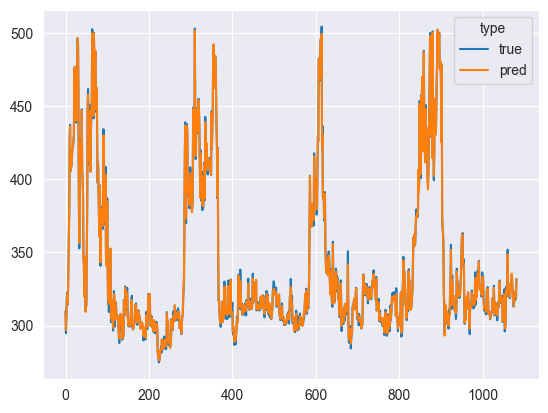

In [46]:
plt.plot(y, label="true")
plt.plot(predictions, label="pred")
plt.legend(title="type")
plt.savefig("predictions.png");

In [47]:
r2_score(y, predictions)

0.9988951239865285

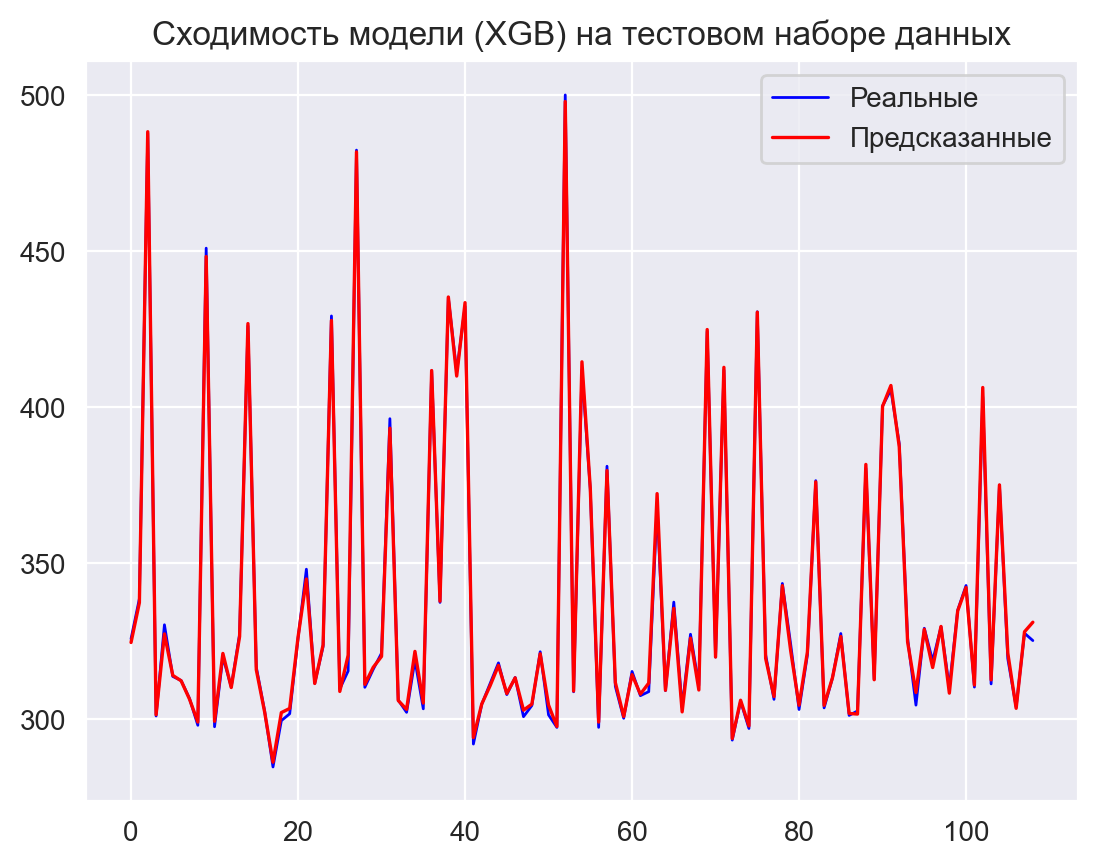

In [48]:
predictions = np.array(model.predict(X_test))
plt.figure(dpi=200)
plt.title("Сходимость модели (XGB) на тестовом наборе данных")
plt.plot(y_test, color="blue", label="Реальные", linewidth=1)
plt.plot(predictions, "r", label="Предсказанные", linewidth=1.2)
plt.legend()
plt.savefig("predictions/graphs/xgb2_test_plot.png")
plt.savefig("predictions/graphs/xgb2_test_plot.svg")
plt.show()

In [49]:
plt.rcParams.update({'font.size': 25})

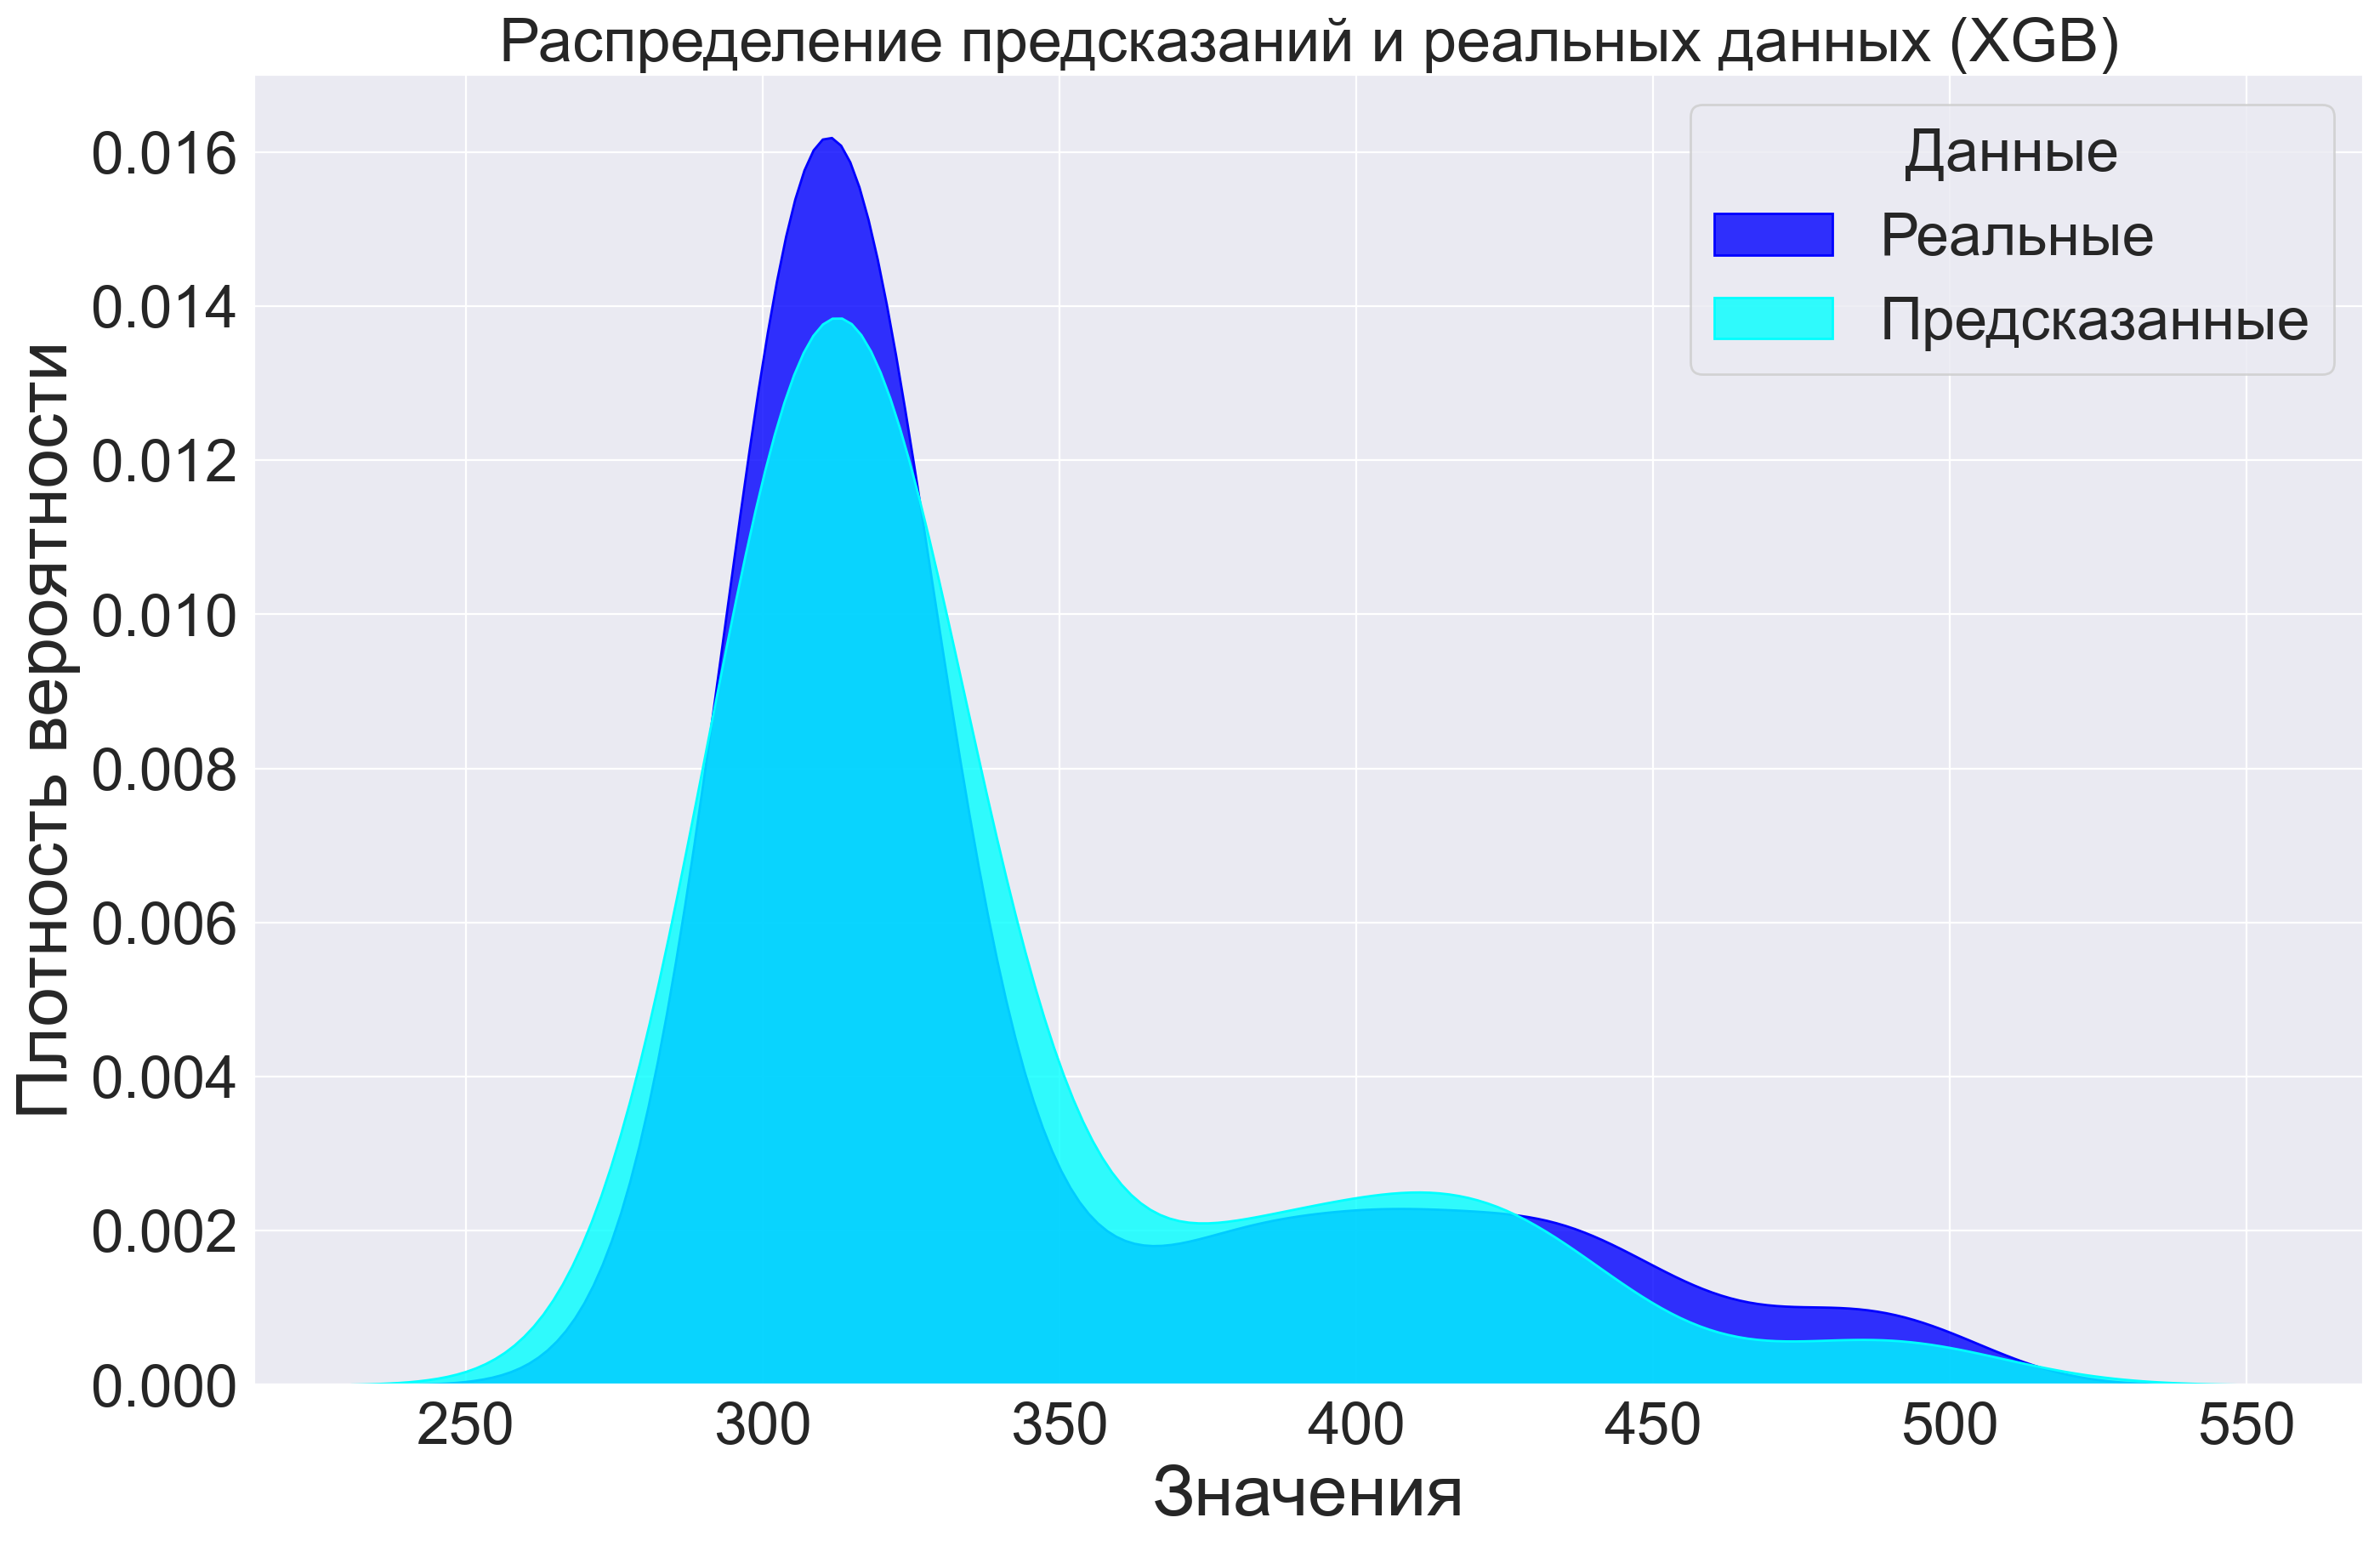

In [50]:
plt.figure(figsize=(16, 10), dpi=200)
sns.kdeplot(
    y, shade=True, color="blue", label="Реальные", alpha=.8
)
sns.kdeplot(
    predictions, shade=True, color="aqua",
    label="Предсказанные", alpha=.8
)
plt.title('Распределение предсказаний и реальных данных (XGB)', fontsize=26)
plt.legend(title="Данные")
plt.xlabel("Значения", fontsize=30)
plt.ylabel("Плотность вероятности", fontsize=30)
plt.savefig("predictions/graphs/xgb_kdeplot.png")
plt.savefig("predictions/graphs/xgb_kdeplot.svg")
plt.show()

In [51]:
for real, pred in zip(y, predictions):
    if abs(real - pred) > 20:
        print(
            "real: {0}, pred: {1}, diff: {2}".format(
                real, pred, abs(real - pred)
            )
        )

real: 294.82969, pred: 337.3197326660156, diff: 42.4900426660156
real: 305.900684, pred: 488.20556640625, diff: 182.30488240625
real: 343.910608, pred: 306.4136962890625, diff: 37.496911710937525
real: 361.624141, pred: 299.07440185546875, diff: 62.54973914453126
real: 379.244772, pred: 448.2105712890625, diff: 68.96579928906249
real: 429.177924, pred: 299.3097839355469, diff: 129.86814006445314
real: 437.292468, pred: 321.05084228515625, diff: 116.24162571484374
real: 405.468105, pred: 310.1241455078125, diff: 95.34395949218748
real: 407.873752, pred: 326.4411315917969, diff: 81.43262040820315
real: 412.053563, pred: 315.8299255371094, diff: 96.22363746289062
real: 418.816147, pred: 302.280029296875, diff: 116.536117703125
real: 421.140593, pred: 286.20050048828125, diff: 134.94009251171877
real: 422.524854, pred: 302.0964660644531, diff: 120.42838793554688
real: 425.59437, pred: 303.4183044433594, diff: 122.17606555664065
real: 430.854225, pred: 326.2375793457031, diff: 104.616645654

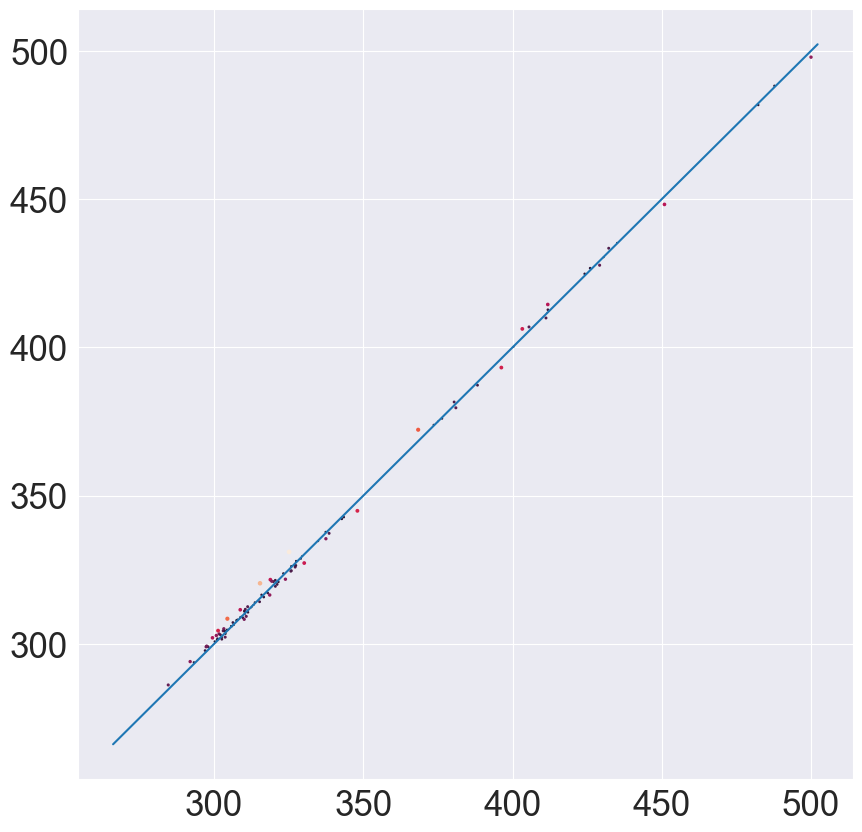

In [52]:
test_predictions = np.array(model.predict(X_test))
area = abs(y_test - test_predictions)
plt.figure(figsize=(10, 10))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(y_test, test_predictions, marker='o', s=area, c=area);

In [53]:
if not os.path.isdir("models"):
    os.mkdir("models")

In [54]:
with open("models/xgb_fuelTA130_099889.bf", "+wb") as file:
    pickle.dump(model, file)

In [55]:
excel = XGBtoExcel(model)
excel.save_expr("models/xgb0.99.txt")

Saved!


In [56]:
len(XGBtoExcel(model).expression)

107889

# XGB + grid search

In [57]:
X = np.array(X)
y = np.array(y)

In [58]:
model = XGBRegressor(n_estimators=100, max_depth=10, alpha=2)

In [59]:
model.fit(X_train, y_train)

XGBRegressor(alpha=2, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [60]:
predictions = np.array(model.predict(X_test))

In [61]:
r2_score(y_test, predictions)

0.9400642843505153

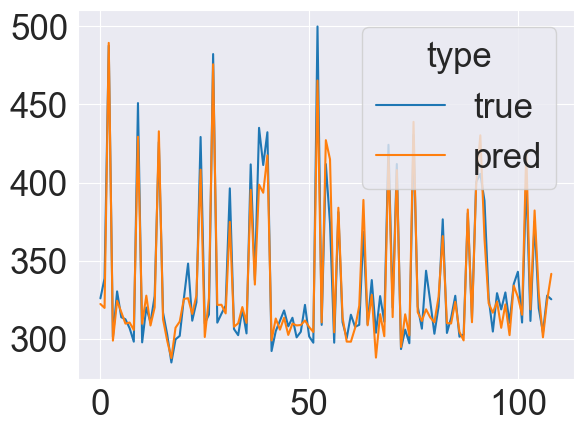

In [62]:
plt.plot(np.array(y_test), label="true")
plt.plot(predictions, label="pred")
plt.legend(title="type")
plt.savefig("predictions.png");

In [63]:
for real, pred in zip(y_test, predictions):
    if abs(real - pred) > 20:
        print(
            "real: {0}, pred: {1}, diff: {2}".format(
                real, pred, abs(real - pred)
            )
        )

real: 450.898516, pred: 429.3163146972656, diff: 21.582201302734347
real: 348.03684, pred: 325.85430908203125, diff: 22.182530917968734
real: 429.177924, pred: 408.2340087890625, diff: 20.94391521093752
real: 396.255965, pred: 374.7566833496094, diff: 21.49928165039063
real: 435.033737, pred: 398.6337585449219, diff: 36.3999784550781
real: 499.985903, pred: 465.36773681640625, diff: 34.61816618359376
real: 373.586281, pred: 414.8512268066406, diff: 41.26494580664064
real: 368.395934, pred: 388.842529296875, diff: 20.44659529687499
real: 343.471583, pred: 318.7391662597656, diff: 24.732416740234385
real: 405.523996, pred: 430.2541198730469, diff: 24.730123873046864
real: 388.270435, pred: 363.76861572265625, diff: 24.50181927734377


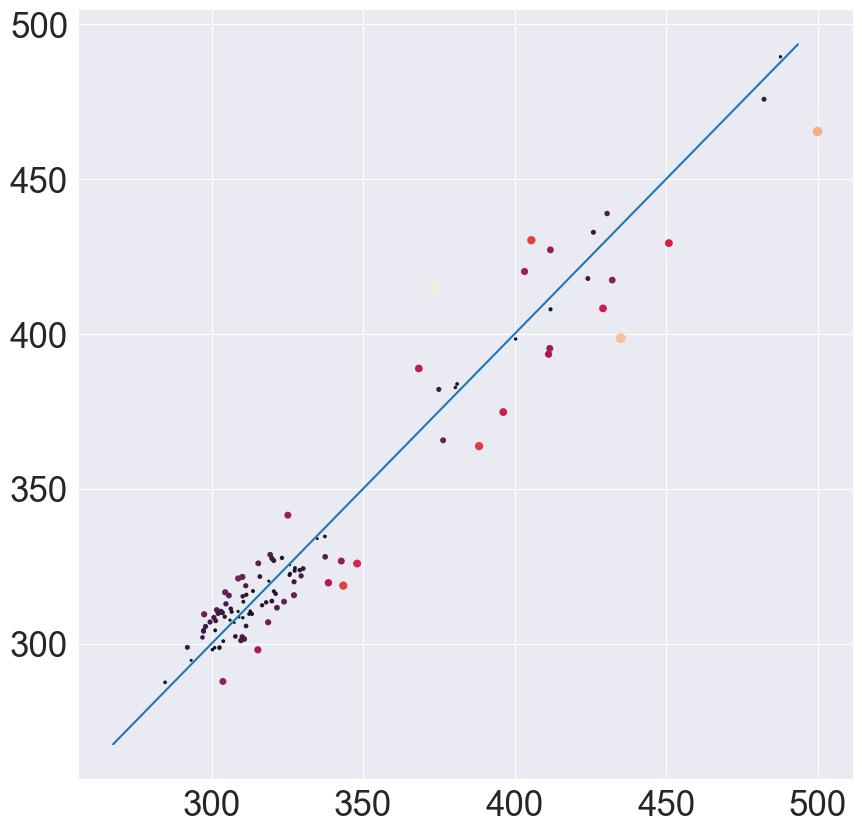

In [64]:
test_predictions = np.array(model.predict(X_test))
area = abs(y_test - test_predictions)
plt.figure(figsize=(10, 10))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(y_test, test_predictions, marker='o', s=area, c=area);

In [65]:
model.fit(X, y)

XGBRegressor(alpha=2, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [66]:
predictions = np.array(model.predict(X))

In [67]:
r2_score(y, predictions)

0.999943761839034

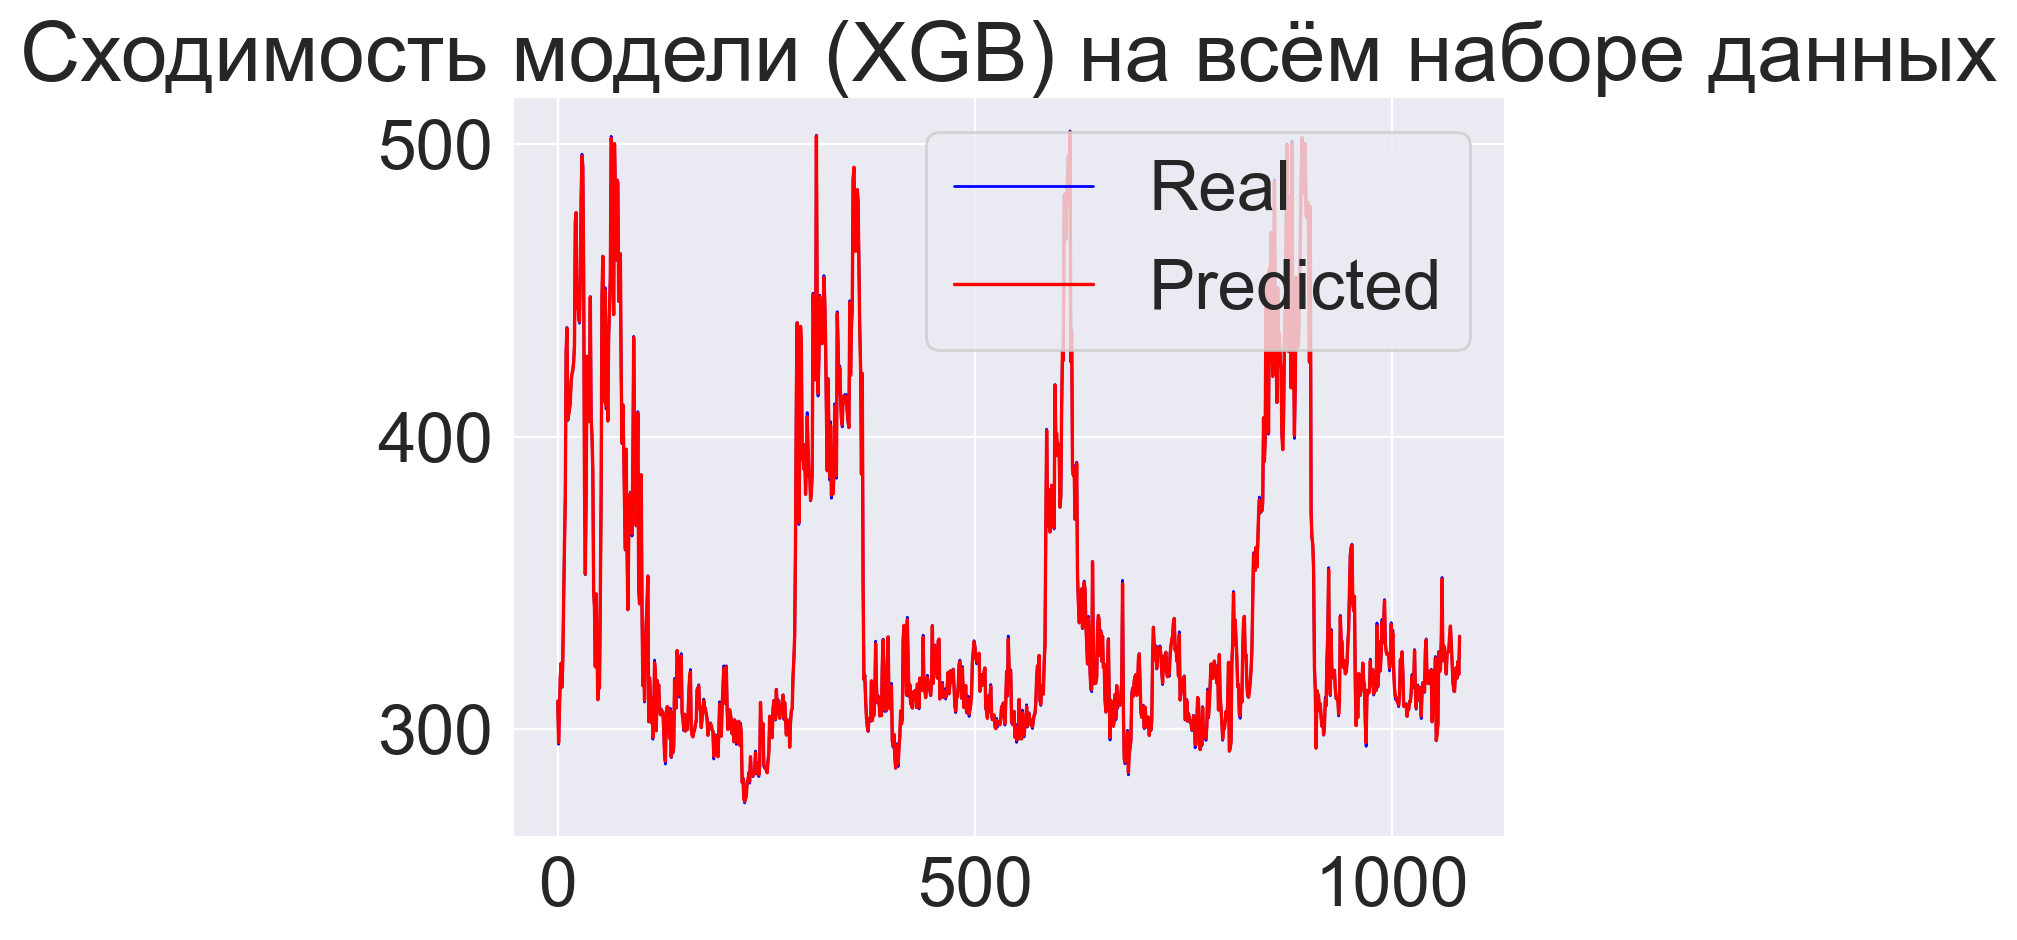

In [68]:
plt.figure(dpi=200)
plt.title("Сходимость модели (XGB) на всём наборе данных")
plt.plot(y, color="blue", label="Real", linewidth=1)
plt.plot(predictions, "r", label="Predicted", linewidth=1.2)
plt.legend()
plt.savefig("predictions/graphs/xgb_plot.png")
plt.savefig("predictions/graphs/xgb_plot.svg")
plt.show()

In [69]:
with open("models/xgb_fuelTA130_099994.bf", "+wb") as file:
    pickle.dump(model, file)